In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import CoolProp.Plots as CPP
from scipy.optimize import fsolve

In [2]:
#approximating mdot
GPH2Kgs = .00078 #gallons per hour (steam evaporated) to kg/s
mdot_sap_high = 12*GPH2Kgs

Pa = 101.3 * 10**3 # average ambient pressure [Pa]
mdot_sap_low = .001 #[kg/s]
#Qdot_fire = 20000 #[20 kW from stove]



# Setting the width and length of the preheating pan
pre_panL = 1
pre_panW = .5
pre_panA = pre_panL* pre_panW

In [3]:
Tsapi = 278 # [K] about 40F

# Calculate temperature of the steam as the boiling point of sap
sugar_amount = 66.9 # Percent g sugar per 100 g solution for maple syrup [Brix]
kb = 0.51 # molal boiling point elevation[°C*kg/mol]
Tbpe = 0.51 * (sugar_amount / 342.3)/((100-sugar_amount)/1000) # Calculate molality of solution in mols sugar/kg water


In [4]:
# Define the parameters to solve for h
Tsteam = 373.15 + Tbpe # Temperature to boil water plus the boiling point elevation due to sugar content
kcond = CP.PropsSI('CONDUCTIVITY','P',Pa,'T', Tsteam ,'water') # Thermal conductivity of steam, W/m K
g = 9.81 # Acceleration due to graviy, m/s^2
beta = 1/Tsteam # Coefficient of thermal expansion, equal to 1/T for ideal gases
cp_steam = CP.PropsSI('C','P',Pa,'T', Tsteam ,'water') # Specific heat capacity at constant pressure, J/kg K
mu = CP.PropsSI('V','P',Pa,'T', Tsteam ,'water') # Dynamic viscosity of steam, Pa-s
density = CP.PropsSI('D','P',Pa,'T', Tsteam ,'water') # Density of steam kg/m^3
v = mu/density # Kinematic viscosity of steam, m^2/s
Lc = (pre_panA)/(2*pre_panL + 2*pre_panW) # Characteristic length for Nusselt number, m
cp_sap = CP.PropsSI('C','P',Pa,'T', Tsapi,'water')
mdot_sap = mdot_sap_high #defining mdot of the sap and therefore steam

In [5]:
# Define a function to numerically solve for Tout of the sap
# Since Tout of sap is a function of the heat transfer to the plate, which is itself a function of Toutsap
# We need to set the increase in temperature of the sap equal to the convective heat transfer and numerically solve
# We use a Nusselt correlation for an isothermal flat plate with free convection from the underside

def ToutFunc(Tsapout):
    n1 = pre_panA/(mdot_sap * cp_sap) * (kcond/Lc)
    Pr = (cp_steam * mu/kcond)
    Gr = (g * beta * np.abs(Tsteam-Tsapout) * Lc**3)/(v**3)
    result = n1 * 0.27 * (Pr * Gr)**(1/4)  - (Tsapout - Tsapi)/(Tsteam - Tsapout)
    return result

In [16]:
Tsapout = fsolve(ToutFunc, 273+40)[0]
print(Tsapout)

310.5986343882281


In [7]:
def simpleEvap(mdot_sap, Tsap, Tsteam=375):
    hsap = CP.PropsSI('H','P',Pa,'T', Tsap,'water') #[j/kg]
    hsteam = CP.PropsSI('H','P',Pa,'T', Tsteam ,'water') #[j/kg]
    Qdot_need = mdot_sap*(hsteam - hsap)
    return Qdot_need

In [23]:
def heatCompare(mdot_sap, Tsapi, Tsteam = 375) :
    Q_noHX = simpleEvap(mdot_sap, Tsapi, Tsteam=375)
    Q_HX = simpleEvap(mdot_sap, Tsapout, Tsteam=375)
    return Q_noHX - Q_HX

In [25]:
heatCompare(mdot_sap_high, Tsapi)

1277.3042262090603

In [26]:
n=30 
mdots = np.linspace(mdot_sap_low, mdot_sap_high, n)

results = []
for j in range(0, n):
    if j == 0:
        results = [heatCompare(mdots[j], Tsapi)]
    else:
        results.append(heatCompare(mdots[j], Tsapi))


Text(0.5, 1.0, 'Heat saved in relation to Mass Flow')

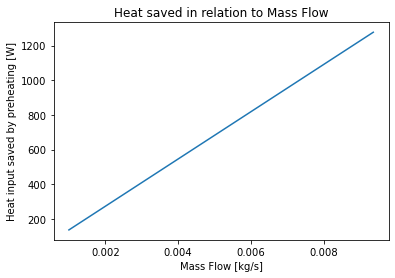

In [28]:
plt.plot(mdots, results)
plt.xlabel('Mass Flow [kg/s]')
plt.ylabel('Heat input saved by preheating [W]')
plt.title('Heat Saved in Relation to Mass Flow')